# Lake model continued - subspace partitioning

In the previous week you used the lake problem as a means of getting acquainted with the workbench. In this assignment we will continue with the lake problem, focussing explicitly on using it for open exploration. You can use the second part of the [open exploration tutorial](https://emaworkbench.readthedocs.io/en/latest/indepth_tutorial/open-exploration.html) for help.

**It is paramount that you are using the lake problem with 100 decision variables, rather than the one found on the website with the seperate anthropogenic release decision**

## 1. Apply scenario discovery

1. Instanciate the model and define its parameters. Use the same parameters as in Assignment 2.
2. Generate 10 policies and 1000 scenarios and evaluate them.
3. The experiments array contains the values for each of the 100 decision levers. This might easily mess up the analysis. Remove these columns from the experiment array. *hint: use `experiments.drop_columns`*
4. Apply scenario discovery, focussing on the 10 percent of worst outcomes for reliability

In [1]:
from lakemodel_function import lake_problem

In [5]:
#initiating the model
from ema_workbench import RealParameter, ScalarOutcome, Constant, Model
from lakemodel_function import lake_problem

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
model = Model("lakeproblem", function=lake_problem)

# specify uncertainties
model.uncertainties = [
    RealParameter("b", 0.1, 0.45),
    RealParameter("q", 2.0, 4.5),
    RealParameter("mean", 0.01, 0.05),
    RealParameter("stdev", 0.001, 0.005),
    RealParameter("delta", 0.93, 0.99),
]

# set levers
model.levers = [
    RealParameter("c1", -2, 2),
    RealParameter("c2", -2, 2),
    RealParameter("r1", 0, 2),
    RealParameter("r2", 0, 2),
    RealParameter("w1", 0, 1),
]

# specify outcomes
model.outcomes = [
    ScalarOutcome("max_P"),
    ScalarOutcome("utility"),
    ScalarOutcome("inertia"),
    ScalarOutcome("reliability"),
]


In [6]:
#generating 10 policies
import numpy as np
from ema_workbench import Policy

# Generate 10 random policies: each is a vector of 100 values ∈ [0.0, 0.1]
policies = []
for i in range(10):
    release = np.random.uniform(0.0, 0.1, size=100)
    lever_dict = {f'l{t}': release[t] for t in range(100)} #create dictionary for levers
    policies.append(Policy(f'policy_{i+1}', **lever_dict)) #append the policies to the experimental setup

In [7]:
#run experiments
from ema_workbench import MultiprocessingEvaluator, ema_logging

ema_logging.log_to_stderr(ema_logging.INFO)

#n_processes number of cores used for parallelization
with MultiprocessingEvaluator(model, n_processes=4) as evaluator:
    #choosing to save experimental uncertainities and outcomes as separate dataframes for ease of analysis
    experiments, outcomes = evaluator.perform_experiments(
        scenarios=1000,
        policies=policies
    )

[MainProcess/INFO] pool started with 4 workers
[MainProcess/INFO] performing 1000 scenarios * 10 policies * 1 model(s) = 10000 experiments
  0%|                                                | 0/10000 [00:00<?, ?it/s]/Users/precupada/decision_making_assignments/venv/lib/python3.13/site-packages/ema_workbench/em_framework/__init__.py:101: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn("ipyparallel not installed - IpyparalleEvaluator not available")
/Users/precupada/decision_making_assignments/venv/lib/python3.13/site-packages/ema_workbench/em_framework/__init__.py:101: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn("ipyparallel not installed - IpyparalleEvaluator not available")
/Users/precupada/decision_making_assignments/venv/lib/python3.13/site-packages/ema_workbench/em_framework/__init__.py:101: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn("ipyparall

[MainProcess/INFO] no time dimension found in results


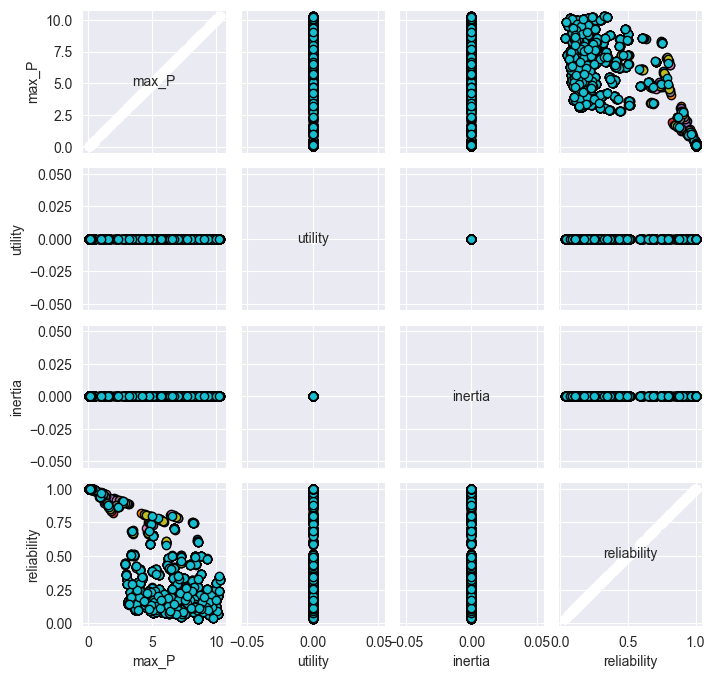

In [18]:
#vizualize results
from ema_workbench.analysis import pairs_plotting

fig, axes = pairs_plotting.pairs_scatter(experiments, outcomes, group_by="policy", legend=False)
fig.set_size_inches(8, 8)
plt.show()

In [27]:
#separate experimental runs from analysis
from ema_workbench import save_results
# 2. Merge experiments and outcomes
outcomes = pd.DataFrame(outcomes)
save_results((experiments,outcomes), '../Ada exercises/data/PRIM lake 1000 scenarios 10 policies.tar.gz')

from ema_workbench import load_results
experiments,outcomes = load_results('../Ada exercises/data/PRIM lake 1000 scenarios 10 policies.tar.gz')

[MainProcess/INFO] results saved successfully to /Users/precupada/decision_making_assignments/Week 3-4 - vulnerability analysis/Ada exercises/data/PRIM lake 1000 scenarios 10 policies.tar.gz
[MainProcess/INFO] results loaded successfully from /Users/precupada/decision_making_assignments/Week 3-4 - vulnerability analysis/Ada exercises/data/PRIM lake 1000 scenarios 10 policies.tar.gz


In [29]:
#even though the assignments suggests the removal of policy levers from the experiments array, in my code, the array is alreayd clean and ready for scenario discovery
# #so we go ahead and determine the 10% worst outcomes for reliability
threshold = np.percentile(outcomes['reliability'], 10)
bad_experiments = outcomes['reliability'] <= threshold


[MainProcess/INFO] column model dropped from analysis because it has only one category
[MainProcess/INFO] 10000 points remaining, containing 1001 cases of interest
[MainProcess/INFO] mean: 0.8431372549019608, mass: 0.051, coverage: 0.42957042957042957, density: 0.8431372549019608 restricted_dimensions: 4


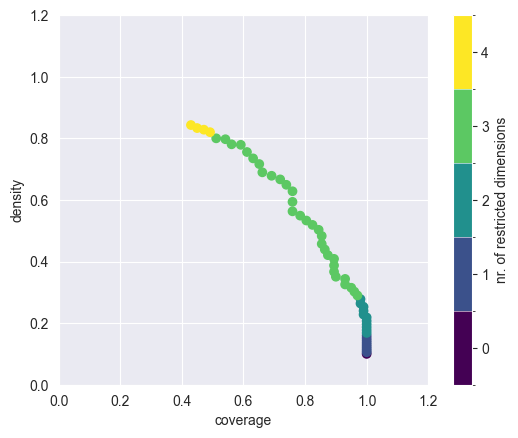

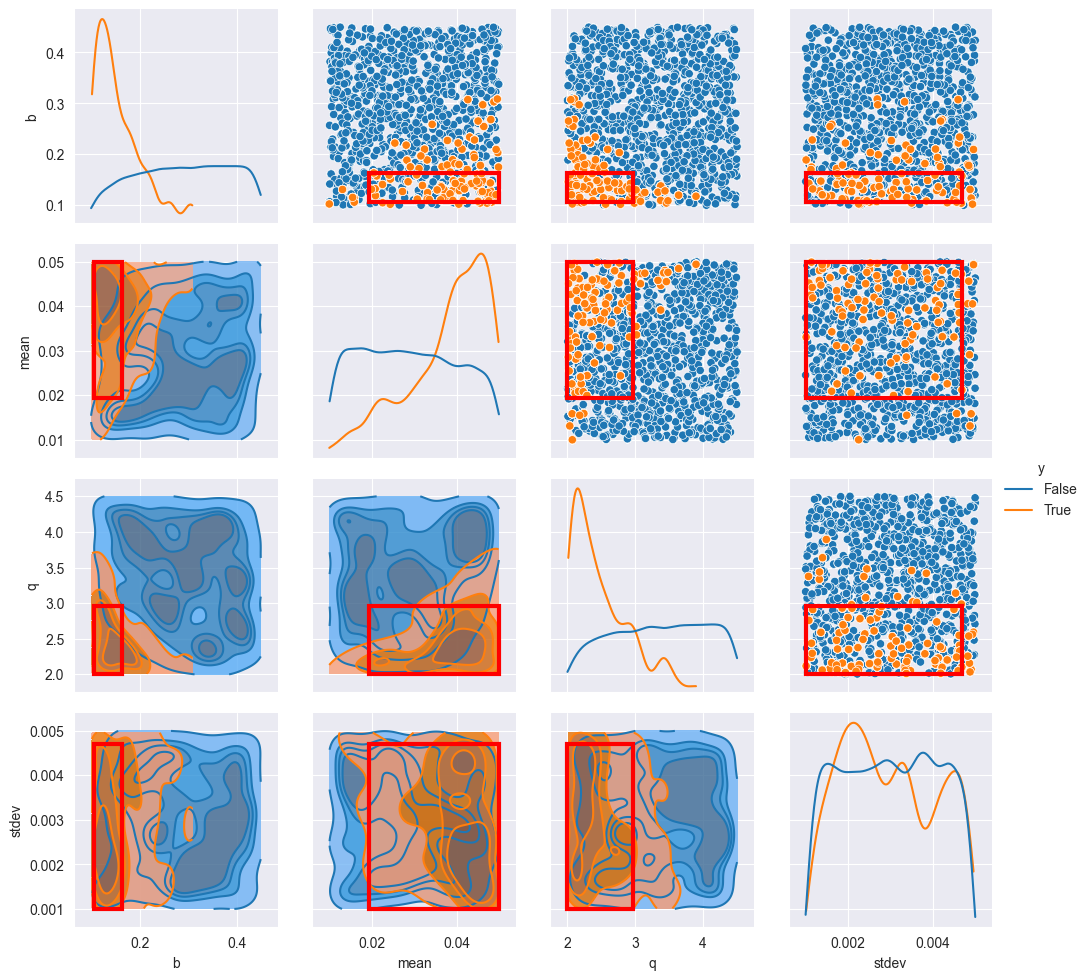

In [41]:
#initiating PRIM
from ema_workbench.analysis import prim

#the default threshold of 0.8 has too little coverage
p = prim.Prim(experiments, bad_experiments, threshold=0.6)
p_box = p.find_box()
p_box.show_tradeoff()
p_box.show_pairs_scatter()

#imagining shows the distribution of stdev doesn't chase much over good or bad experiments, suggesting it's not veyr relvenat and i would restrict the dimension to 3, keeping only the other uncertainities for anlaysis
#low q has high distribution for bad outcomes + high mean + low b
#suggested code to focus only on restricted dimension:

# Focus only on the selected dimensions
# restricted_dims = ['b', 'mean', 'q']
# 
# # Initialize PRIM
# prim_alg = prim.Prim(experiments, bad_experiments, threshold=0.7, peel_alpha=0.1)
# 
# # FIND a box, but only over selected dimensions
# box = prim_alg.find_box(dims=restricted_dims)
# 
# # Visualize
# box.show_tradeoff()
# box.show_pairs_scatter()



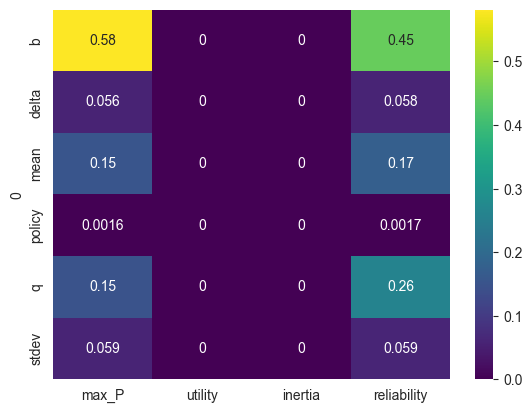

In [34]:
from ema_workbench.analysis import feature_scoring
#additionally, we can also use feature scoring to determine the most important relationships between outcomes
x = experiments
y = outcomes

fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, cmap="viridis", annot=True)
plt.show()


## 2. Visualize the results using Dimensional Stacking
Take the classification of outcomes as used in step 3 of scenario discovery, and instead visualize the results using dimensional stacking. How do these results compare to the insights from scenario discovery?

[MainProcess/INFO] model dropped from analysis because only a single category
/Users/precupada/decision_making_assignments/venv/lib/python3.13/site-packages/ema_workbench/analysis/dimensional_stacking.py:408: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pvt = pd.pivot_table(x_y_concat, values=ooi_label, index=rows, columns=columns, dropna=False)


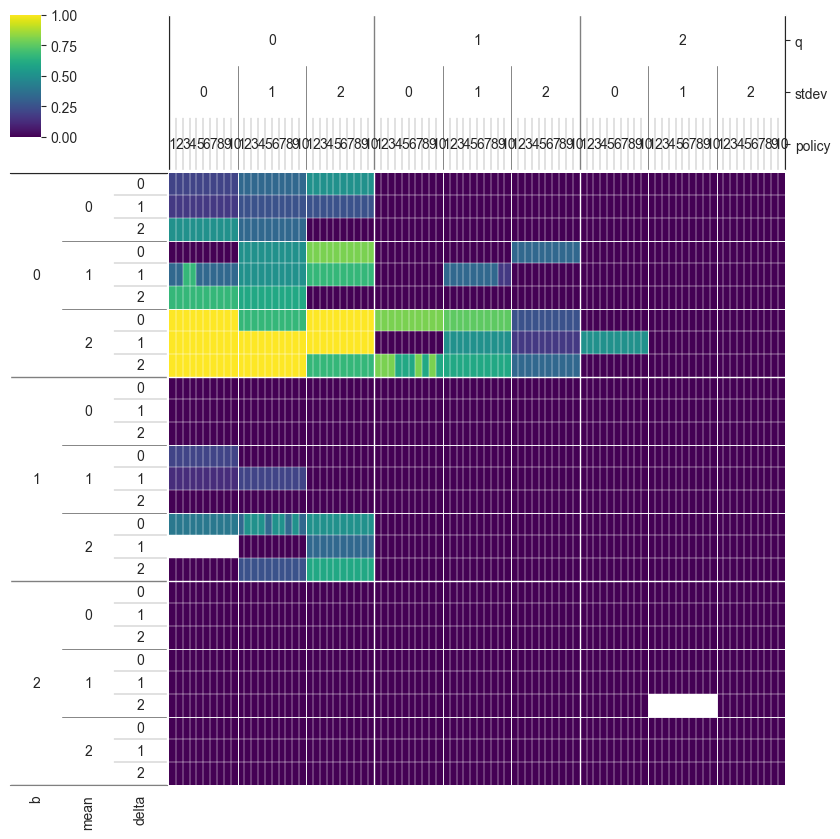

In [40]:
#dimensional stacking = identifying the most important uncertainties that affect system behavior, and creating a pivot table using the most influential uncertainties
from ema_workbench.analysis import dimensional_stacking

#dimensional_stacking.create_pivot_plot(input_uncertainities, boolean_Array_determining_outcomnes_of_interest, number_of_uncertainities_to_plot, nbins=3)
dimensional_stacking.create_pivot_plot(experiments, bad_experiments, 3, nbins=3)
plt.show()

# “Danger zones” (bins with many bad outcomes)
# “Safe zones” (bins with mostly good outcomes)

### Observations
- high mean + low q gather most bad outcomes around them, in alignment with the PRIM insights
- we see almsot no differentiation amongst cases based on stdev value, again underlining it can be restricted from analysis
- we see some variation due to delta in the low q and high mean area, could bee interesting to look into delta in this aggregated situation